In [ ]:
import pandas as pd
import warnings
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.neural_network import MLPClassifier

np.random.seed(42)
dataset = pd.read_csv('HotDataset.csv')

Split 'Mental Health Score' into multiple categories of Mental Health

In [ ]:
bins = [0, 10, 20, 30, 40]
labels = ['Very low', 'Low', 'Moderate', 'High']
dataset['Mental health category'] = pd.cut(dataset['Mental health score'], bins=bins, labels=labels)

X = dataset.drop(['Mental health score', 'Mental health category'], axis=1) # X is the feature
y = dataset['Mental health category'] # y is the target variable

Create pipelines and split training/testing/validation sets

In [ ]:
le = LabelEncoder()
y = le.fit_transform(y)
# Encoded a unique value to the categories, such that
# 0 - [Zero Category]
# 1 - [Very Low 0-10]
# 2 - [Low 10-20]
# 3 - [Moderate 20-30]
# 4 - [High 30-40]

# Split the dataset into train, test and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_test, X_valid, y_test, y_valid = train_test_split(X_test, y_test, test_size=0.5, random_state=42)
# Splitting test set in half, one half remains in test set and the other goes to the validation set

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    # SimpleImputer replaces all missing values with the median
    ('scaler', StandardScaler())])
    # StandardScaler makes each feature have a standard deviation of 1 and a mean of 0

    # NOTE: StandardScaler does not modify the data, it only transforms it to be easier to read by a Machine Learning model.
    # This means the data sent into the model is the exact same as the dataset, only its been standardized
    # More info on https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    # This instance of SimpleImputer replaces missing values with the one that appears most frequently
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
    # Performs OneHotEncoding on categorical values in X
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, X.select_dtypes(include=['int64', 'float64']).columns),
        ('cat', categorical_transformer, X.select_dtypes(include=['object']).columns)
    ]
)

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', GaussianNB())])

pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['Age', 'Hours per day', 'BPM', 'Anxiety', 'Depression', 'Insomnia',
       'OCD'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index([], dtype='object'))])),
                ('classifier', GaussianNB())])

Predict on Testing Set

In [ ]:
y_pred = pipeline.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
accuracy *= 100
print("Naive Bayes Testing Set Metrics:")
print("Accuracy: ", accuracy, "%", sep="")

Naive Bayes Testing Set Metrics:
Accuracy: 86.51685393258427%


Predict on Validation Set

In [ ]:
y_pred_valid = pipeline.predict(X_valid)
accuracy_valid = accuracy_score(y_valid, y_pred_valid)
accuracy_valid *= 100
print("Naive Bayes Validation Set Metrics:")
print("Accuracy: ", accuracy_valid, "%", sep="")

Naive Bayes Validation Set Metrics:
Accuracy: 87.77777777777777%


Classification Report

In [ ]:
print("Classification Report for Gaussian Naive Bayes Classifier:")
labels = ['Zero Category', 'Very Low', 'Low', 'Moderate', 'High']
print(classification_report(y_test, y_pred, target_names=labels))

Classification Report for Gaussian Naive Bayes Classifier:
               precision    recall  f1-score   support

Zero Category       1.00      1.00      1.00         1
     Very Low       0.89      0.80      0.84        40
          Low       0.77      0.96      0.85        24
     Moderate       0.95      0.87      0.91        23
         High       1.00      1.00      1.00         1

     accuracy                           0.87        89
    macro avg       0.92      0.93      0.92        89
 weighted avg       0.87      0.87      0.87        89



In [ ]:
X_test

,Age,Hours per day,BPM,Anxiety,Depression,Insomnia,OCD,Primary streaming service_Apple Music,Primary streaming service_I do not use a streaming service.,Primary streaming service_Other streaming service,...,Frequency [Rock]_Rarely,Frequency [Rock]_Sometimes,Frequency [Rock]_Very frequently,Frequency [Video game music]_Never,Frequency [Video game music]_Rarely,Frequency [Video game music]_Sometimes,Frequency [Video game music]_Very frequently,Music effects_Improve,Music effects_No effect,Music effects_Worsen
585,26.0,1.0,136.0,0.0,0.0,0.0,0.0,False,False,False,...,False,False,False,False,True,False,False,False,True,False
218,20.0,3.0,119.0,8.0,4.0,3.0,4.0,False,False,False,...,False,True,False,True,False,False,False,True,False,False
92,41.0,3.0,113.0,9.0,7.0,6.0,2.0,False,False,False,...,False,False,True,True,False,False,False,False,True,False
356,21.0,1.0,135.0,3.0,0.0,2.0,0.0,False,False,False,...,False,False,False,True,False,False,False,True,False,False
582,16.0,6.0,105.0,10.0,7.0,6.0,10.0,False,False,False,...,False,False,False,True,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
318,32.0,2.0,84.0,4.0,3.0,1.0,6.0,False,False,False,...,False,True,False,False,False,False,True,True,False,False
533,17.0,4.0,120.0,4.0,2.0,0.0,0.0,False,False,False,...,False,False,True,False,False,True,False,True,False,False
101,23.0,2.0,117.0,7.0,3.0,2.0,3.0,False,False,False,...,False,True,False,True,False,False,False,True,False,False
163,33.0,7.0,134.0,9.0,3.0,7.0,8.0,False,False,False,...,False,False,True,False,False,True,False,True,False,False


In [ ]:
print(y_test)

# NOTE: 0 - [Zero Category]
#       1 - [Very Low 0-10]
#       2 - [Low 10-20]
#       3 - [Moderate 20-30]
#       4 - [High 30-40]

[4 1 2 3 0 1 1 1 3 2 2 2 1 1 2 1 1 1 2 1 2 2 1 1 1 1 1 3 1 3 1 2 3 1 1 2 2
 3 2 2 1 2 3 1 2 3 1 2 3 2 1 3 2 3 1 3 3 1 1 1 1 1 1 3 3 3 2 1 1 3 3 2 1 1
 1 3 3 1 3 2 3 1 1 2 1 3 1 2 2]


In [ ]:
print(y_pred)

# NOTE: 0 - [Zero Category]
#       1 - [Very Low 0-10]
#       2 - [Low 10-20]
#       3 - [Moderate 20-30]
#       4 - [High 30-40]

[4 1 2 3 0 1 1 1 1 2 2 2 2 1 2 1 1 1 2 1 2 2 1 1 1 1 3 3 1 3 1 2 3 1 2 2 2
 3 2 2 2 1 3 1 2 1 1 2 3 2 2 3 2 3 1 3 3 1 1 1 1 2 1 1 3 3 2 2 1 3 3 2 1 1
 1 3 3 1 3 2 3 2 1 2 1 3 1 2 2]


Table comparing actual value to predicted value

In [ ]:
reg_model_diff = pd.DataFrame({'Actual value': y_test, 'Predicted value': y_pred})
reg_model_diff

,Actual value,Predicted value
0,4,4
1,1,1
2,2,2
3,3,3
4,0,0
...,...,...
84,1,1
85,3,3
86,1,1
87,2,2


Scatter plot showing the above table

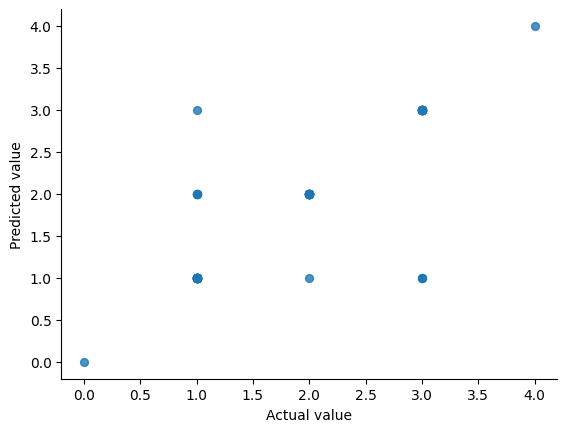

In [ ]:
reg_model_diff.plot(kind='scatter', x='Actual value', y='Predicted value', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

Confusion Matrix

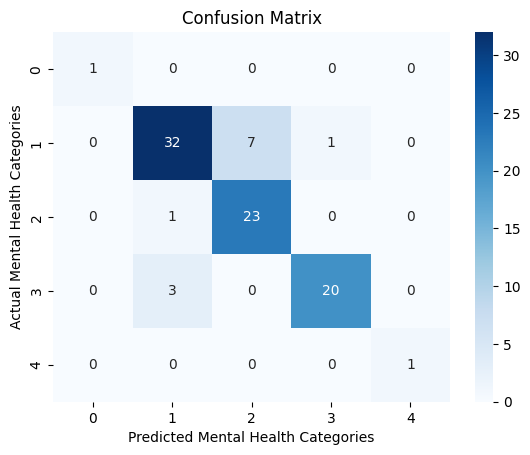

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted Mental Health Categories')
plt.ylabel('Actual Mental Health Categories')
plt.title('Confusion Matrix')
plt.show()